## Import Packages

In [1]:
import math
import numpy as np
from itertools import cycle
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

## Mean-Shift Implementation

In [2]:
class MeanShift:
    def __init__(self, band_width=2.0, min_fre=3, epsilon=None, bin_seeding=False, bin_size=None):
        self.epsilon = epsilon if epsilon else 1e-3 * band_width
        self.bin_size = bin_size if bin_size else self.band_width
        self.band_width = band_width
        self.min_fre = min_fre  # 可以作为起始质心的球体内最少的样本数目
        self.bin_seeding = bin_seeding
        self.radius2 = self.band_width ** 2  # 高维球体半径的平方

        self.N = None
        self.labels = None
        self.centers = []

    def init_param(self, data):
        # 初始化参数
        self.N = data.shape[0]
        self.labels = -1 * np.ones(self.N)
        return

    def get_seeds(self, data):
        # 获取可以作为起始质心的点（seed）
        if not self.bin_seeding:
            return data
        seed_list = []
        seeds_fre = defaultdict(int)
        for sample in data:
            seed = tuple(np.round(sample / self.bin_size))  # 将数据粗粒化，以防止非常近的样本点都作为起始质心
            seeds_fre[seed] += 1
        for seed, fre in seeds_fre.items():
            if fre >= self.min_fre:
                seed_list.append(np.array(seed))
        if not seed_list:
            raise ValueError('the bin size and min_fre are not proper')
        if len(seed_list) == data.shape[0]:
            return data
        return np.array(seed_list) * self.bin_size

    def euclidean_dis2(self, center, sample):
        # 计算均值点到每个样本点的欧式距离（平方）
        delta = center - sample
        return delta @ delta

    def gaussian_kel(self, dis2):
        # 计算高斯核
        return 1.0 / self.band_width * (2 * math.pi) ** (-1.0 / 2) * math.exp(-dis2 / (2 * self.band_width ** 2))

    def shift_center(self, current_center, data):
        # 计算下一个漂移的坐标
        denominator = 0  # 分母
        numerator = np.zeros_like(current_center)  # 分子, 一维数组形式
        for sample in data:
            dis2 = self.euclidean_dis2(current_center, sample)
            if dis2 <= self.radius2:
                d = self.gaussian_kel(dis2)
                denominator += d
                numerator += d * sample
        if denominator > 0:
            return numerator / denominator
        else:
            return None

    def classify(self, data):
        # 根据最近邻将数据分类到最近的簇中
        center_arr = np.array(self.centers)
        for i in range(self.N):
            delta = center_arr - data[i]
            dis2 = np.sum(delta * delta, axis=1)
            self.labels[i] = np.argmin(dis2)
        return

    def fit(self, data):
        # 训练主函数
        self.init_param(data)
        seed_list = self.get_seeds(data)
        for seed in seed_list:
            bad_seed = False
            current_center = seed
            # 进行一次独立的均值漂移
            while True:
                next_center = self.shift_center(current_center, data)
                if next_center is None:
                    bad_seed = True
                    break
                delta_dis = np.linalg.norm(next_center - current_center, 2)
                if delta_dis < self.epsilon:
                    break
                current_center = next_center
            if not bad_seed:
                # 若该次漂移结束后，最终的质心与已存在的质心距离小于带宽，则合并
                for i in range(len(self.centers)):
                    if np.linalg.norm(current_center - self.centers[i], 2) < self.band_width:
                        break
                else:
                    self.centers.append(current_center)
        self.classify(data)
        return

## Generate Samples

In [3]:
def generate_samples(mean, var, num):
    samples = []
    samples.append(mean[0] + np.random.randn(num) * var[0])
    samples.append(mean[1] + np.random.randn(num) * var[1])
    return samples

samples1 = generate_samples([-2, -2], [1, 1], 200)
samples2 = generate_samples([2, 2], [1, 1], 200)
samples = np.vstack([np.hstack([samples1[0], samples2[0]]) , np.hstack([samples1[1], samples2[1]])])
samples = samples.T

## Clustering

In [4]:
MS = MeanShift(band_width=3, min_fre=3, bin_size=4, bin_seeding=True)
MS.fit(samples)
labels = MS.labels

## Visualization Raw Data

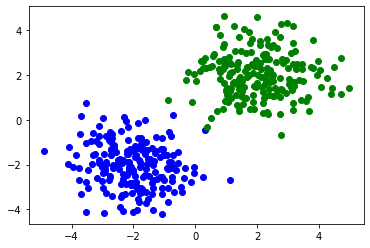

In [5]:
fig = plt.figure()
for i in range(200):
    plt.plot(samples1[0][i], samples1[1][i], 'o', c='b')
for i in range(200):
    plt.plot(samples2[0][i], samples2[1][i], 'o', c='g')
plt.savefig("fig1.png")
plt.show()
plt.close()

## Visualization Clustering Data

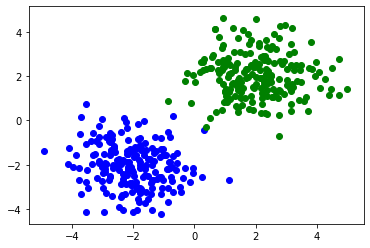

In [6]:
def visualize(data, labels):
    color = 'bgrymk'
    unique_label = np.unique(labels)
    for col, label in zip(cycle(color), unique_label):
        partial_data = data[np.where(labels == label)]
        plt.scatter(partial_data[:, 0], partial_data[:, 1], color=col)
    plt.show()
    return

fig = plt.figure()
visualize(samples, labels)
plt.savefig("fig2.png")
plt.close()